In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
from time import time

## Define function

In [2]:
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO_complex(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

## Generate random wave

In [3]:
## Meshgrid
n_grid = 256
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

## Random wave
sigma_k = 0.025
kappa = 128
alpha = 0.25

#### Wave vector distribution ####
k_mean_z = np.array([0,0,10])*2*np.pi # lamellar perpendicular to z axis 
# k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([0,0,sigma_k*10])*2*np.pi)**2
k_cov  = np.diagflat(k_var)

rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 60, kappa=kappa)

In [4]:
rho_real = rho.real
rho_imag = rho.imag
rho_phase = np.angle(rho)

In [5]:
## identify vortex line (cube, not working)
# example of a single cube
# '''
#     (4)--------(7)
#     /|         /|
#    / |        / |
#  (3)--------(5) |
#   | (2)------|-(6)
#   | /        | /
#   |/         |/
#  (0)--------(1)
# '''
# cube_coord = np.array([0,0,0])
# list_vertices = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], 
#                  [0,1,1], [1,0,1], [1,0,1], [1,1,1]]
# list_faces = [[0,1,6,2],[3,4,7,5],[0,3,5,1],[2,6,7,4],[0,2,4,3],[1,5,7,6]]
# cube_vertices = np.array(list_vertices) + cube_coord


In [6]:
## identify vortex line (slice of plane)
def vortex_slice(phase_slice):
    '''
    Input
    phase_slice: 2D array of phase field (floats, -pi to pi).

    Output
    vortex_array: 2D array of vortex locations (binary)
    ----------------------------------------------------------------
     --- --- ---
    | 1 | 8 | 7 |
    --- --- --- 
    | 2 | p | 6 |
    --- --- ---
    | 3 | 4 | 5 |
    --- --- ---
    A pixel is identified as a vortex if the phase difference along 
    the encircling path exceeds pi for an odd number of times.
    '''
    # list_cells = np.array([[-1,1], [-1,0], [-1,-1], [0,-1], [1,-1], [1,0], [1,1], [0,1]])

    vortex_array = np.zeros_like(phase_slice)
    # evaluate the phase difference
    pd_u = phase_slice[:,1:]-phase_slice[:,0:-1]
    pd_d = phase_slice[:,0:-1]-phase_slice[:,1:]
    pd_l = phase_slice[0:-1,:]-phase_slice[1:,:]
    pd_r = phase_slice[1:,:]-phase_slice[0:-1,:]
    
    for i in range(phase_slice.shape[0]-2):
        for j in range(phase_slice.shape[0]-2):
            center_coord = np.array([i+1,j+1])
            # cells_coord = center_coord + list_cells
            # phase_coord = [phase_slice[k] for k in zip(*cells_coord.T)]
            # phase_diff = np.array([(phase_coord[(i+1)%8]-phase_coord[i%8]) for i in range(8)])
            phase_diff = np.array([pd_d[i+1-1,j+1],pd_d[i+1-1,j],
                                   pd_r[i,j+1-1],pd_r[i+1,j+1-1],
                                   pd_u[i+1+1,j],pd_u[i+1+1,j+1], 
                                   pd_l[i+1,j+1+1],pd_l[i,j+1+1]])

            if np.sum(np.abs(phase_diff)>np.pi)%2>0:
                vortex_array[i+1,j+1] = 1

    return vortex_array


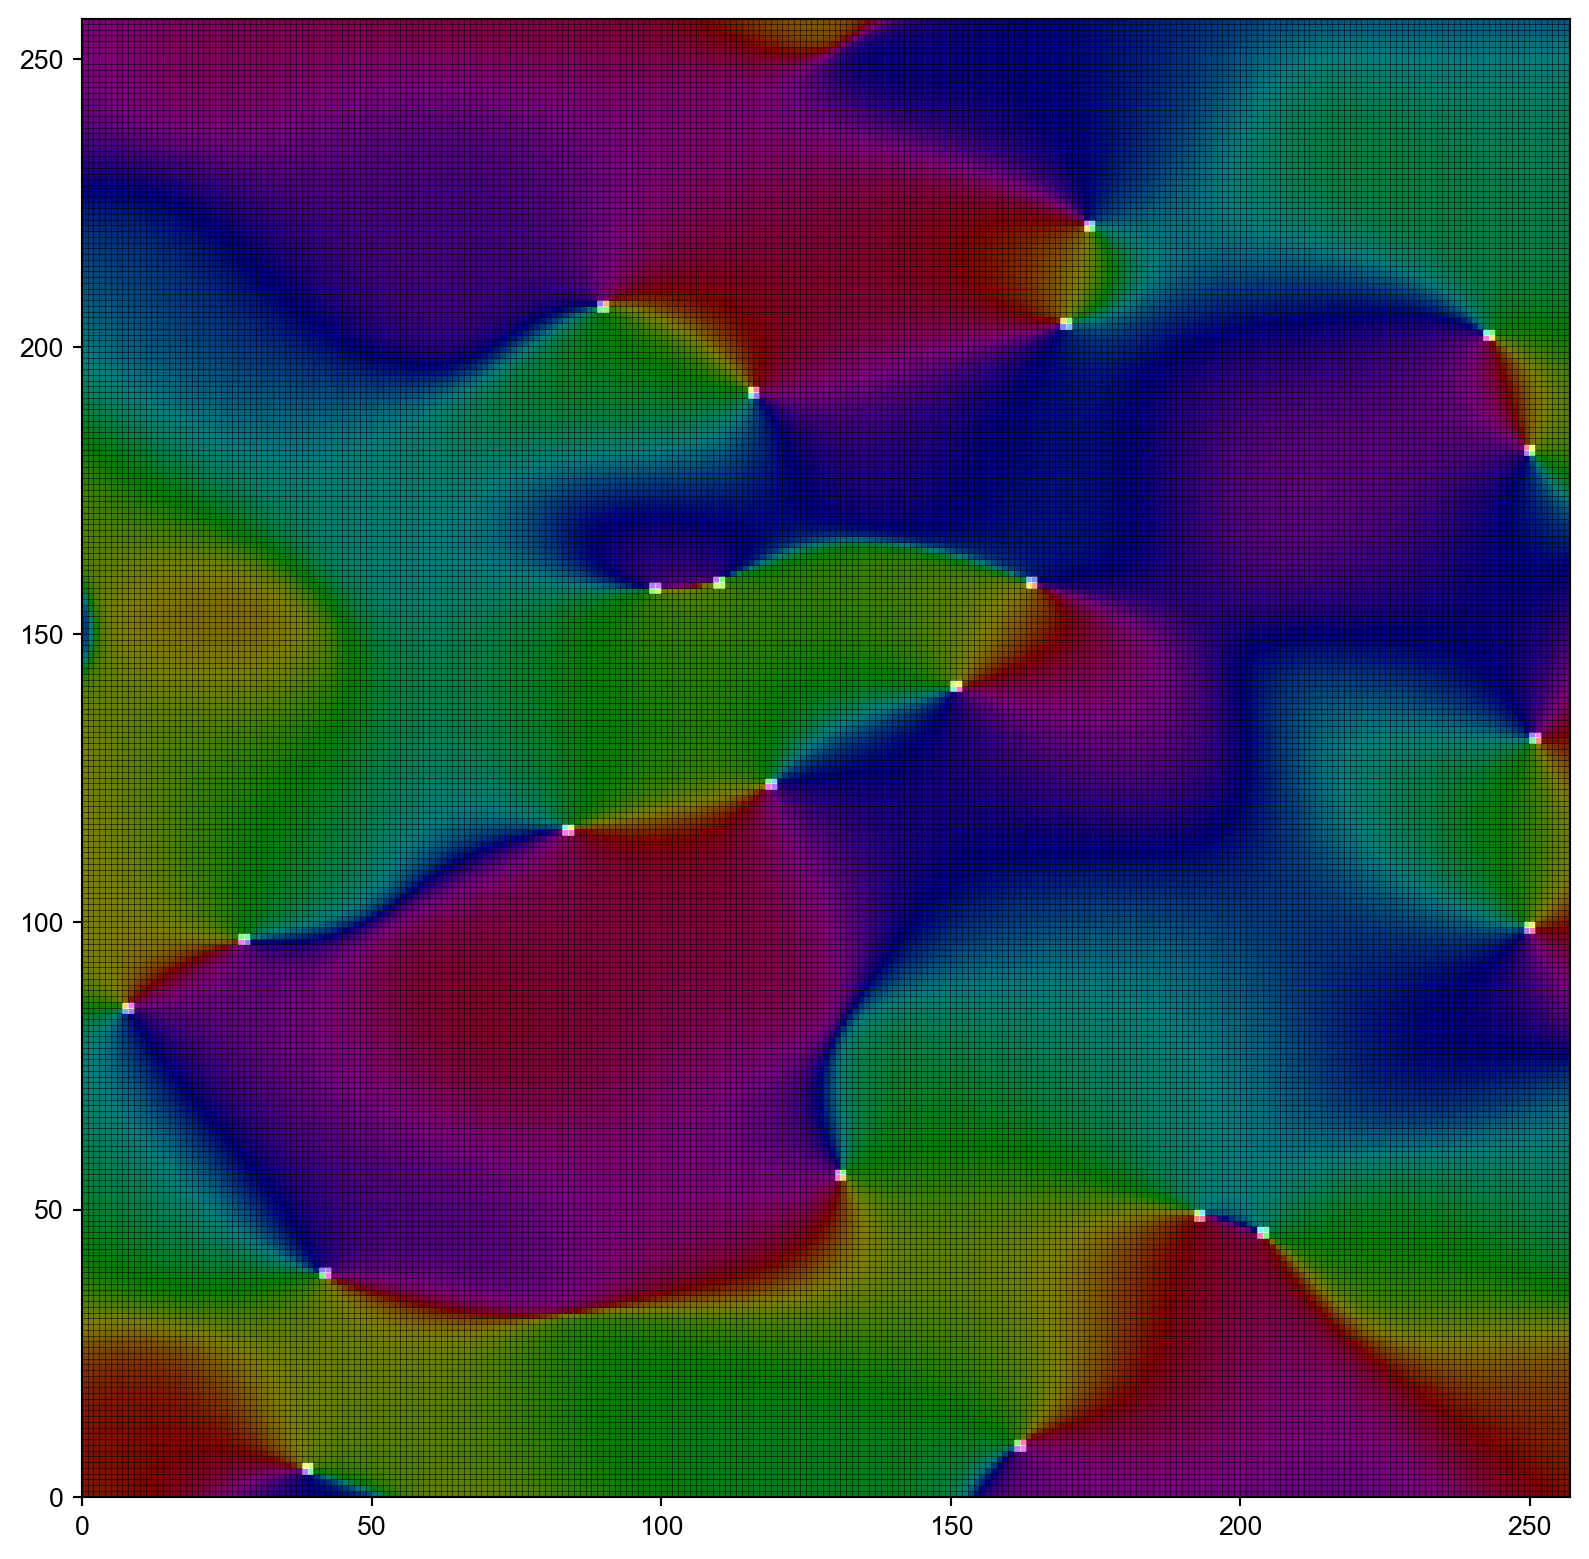

In [7]:
example_slice = rho_phase[:,:,0]
vortex_array = vortex_slice(example_slice)

#### plotting
fig = plt.figure(figsize=(10,10),dpi=192)
ax = fig.add_subplot(1, 1, 1)

ax.pcolor(example_slice, vmin=-np.pi, vmax=np.pi, 
        cmap='hsv')
ax.pcolor(vortex_array, vmin=0, vmax=1, 
        cmap='gray', alpha=0.5)
ax.grid(True, which='minor', axis='both', linestyle='-', color='k', lw=2)

In [8]:
## scanning over the simulation cell
n_slices = rho_phase.shape[1]
vortex_volume = np.ones_like(rho_phase)
for ax in range(3):
    axis_slice = ax
    vortex_array_list = []
    for i in trange(n_slices):
        rho_phase_slices = rho_phase.take(indices = i, axis=axis_slice)
        vortex_array = vortex_slice(rho_phase_slices)
        vortex_array_list.append(vortex_array)

    vortex_volume_ax = np.array(vortex_array_list)
    vortex_volume_ax = np.moveaxis(vortex_volume_ax,0,axis_slice)
    vortex_volume = vortex_volume*(1-vortex_volume_ax)

vortex_volume = 1-vortex_volume

  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [01:48<00:00,  2.36it/s]


In [9]:
np.min(vortex_volume)

0.0

## Visualization

In [10]:
def visualize_lamellar(rho_real,vortex_volume,
                       lamellar=True,filename = './test_lamellar_vortex.png'):
    # pyvista
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho_real.flatten('F')
    mesh = grid.contour([alpha])

    grid["vol"] = vortex_volume.flatten('F')
    mesh2 = grid.contour([0.5])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    if lamellar:
        backface_params = dict(color='#303030',
                            ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                            opacity=1
                            )
        pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                    ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                    backface_params=backface_params, 
                    smooth_shading=True, 
                    opacity=1
                    )

    backface_params_defect = dict(color='#FF0000',
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                        opacity=0.5
                        )
    pl.add_mesh(mesh2, show_scalar_bar=False, color='#FF0000',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params_defect, 
                smooth_shading=True, 
                opacity=0.5
                )

    # camera setting
    pl.camera_position = 'yz'
    pl.camera.azimuth = -60.0
    pl.camera.elevation = 24.0
    pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    pl.add_bounding_box()
    pl.show(screenshot=filename)
    # pl.close(render=False)

In [11]:
visualize_lamellar(rho_real, vortex_volume)

Widget(value="<iframe src='http://localhost:63327/index.html?ui=P_0x26ef6d23b50_0&reconnect=auto' style='width…

In [12]:
visualize_lamellar(rho_real, vortex_volume, lamellar=False, filename='./test_vortex.png')

Widget(value="<iframe src='http://localhost:63327/index.html?ui=P_0x26e94696190_1&reconnect=auto' style='width…